In [ ]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import bs 
import pandas as pd
import numpy as np
import plotly.express as px
#import plotly.graph_objects as go
#from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
#import wandb
#import xgboost as xgb
#from econml.dml import CausalForestDML
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import os 

In [ ]:


#confi de CI 
base_path = os.getenv("DATA_PATH", "../dados/microdados_enem_2019/")

file_path = os.path.join(base_path, "dados_enem_processados.csv.zip")
df = pd.read_csv(file_path)

In [7]:
#path_to_the_truth= r"../dados/microdados_enem_2019/dados_enem_processados.csv.zip"
#df= pd.read_csv(path_to_the_truth, sep=",", encoding="utf-8", compression="zip")

df.columns

Index(['NU_INSCRICAO', 'TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ESTADO_CIVIL',
       'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU',
       'TP_ESCOLA', 'TP_ENSINO', 'SG_UF_ESC', 'TP_DEPENDENCIA_ADM_ESC',
       'TP_LOCALIZACAO_ESC', 'TP_SIT_FUNC_ESC', 'N_PESSOAS_MESMA_RED',
       'INTERNET', 'MEDIA_CANDIDATO', 'SCORE_CONSUMO', 'SCORE_CULT_PAIS',
       'RENDA'],
      dtype='object')

In [3]:
df.head()

,NU_INSCRICAO,TP_FAIXA_ETARIA,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,SG_UF_ESC,TP_DEPENDENCIA_ADM_ESC,TP_LOCALIZACAO_ESC,TP_SIT_FUNC_ESC,N_PESSOAS_MESMA_RED,INTERNET,MEDIA_CANDIDATO,SCORE_CONSUMO,SCORE_CULT_PAIS,RENDA
0,190001867757,2,1,1,1,1,2,0,3,1.0,0,4.0,1.0,1.0,2,1,722.58,18,8.0,2245
1,190001692704,3,1,1,1,1,2,0,2,1.0,1,2.0,1.0,1.0,3,0,477.44,13,4.0,0
2,190001595660,2,1,1,2,1,2,0,2,1.0,2,2.0,1.0,1.0,3,1,498.76,7,11.0,499
3,190001421552,2,0,1,2,1,2,0,2,1.0,3,2.0,1.0,1.0,2,1,614.34,7,5.0,499
4,190001480443,3,0,2,3,4,2,0,2,1.0,4,2.0,1.0,1.0,4,1,422.28,11,6.0,1247


In [4]:
df.set_index("NU_INSCRICAO", inplace=True)

In [4]:
df.columns

Index(['TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA',
       'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ESCOLA',
       'TP_ENSINO', 'SG_UF_ESC', 'TP_DEPENDENCIA_ADM_ESC',
       'TP_LOCALIZACAO_ESC', 'TP_SIT_FUNC_ESC', 'N_PESSOAS_MESMA_RED',
       'INTERNET', 'MEDIA_CANDIDATO', 'SCORE_CONSUMO', 'SCORE_CULT_PAIS',
       'RENDA'],
      dtype='object')

Vamos usar somente colunas pós tratamentos

Primeiro Modelo Base 

In [7]:
#vamos normalizar as colunas de renda, riqueza e capital cultural, para podermos comparar os coeficientes depois
scaler = StandardScaler()
df_copy= df.copy()
df_copy[['RENDA', 'SCORE_CULT_PAIS', 'SCORE_CONSUMO']] = scaler.fit_transform(df_copy[['RENDA',  'SCORE_CULT_PAIS', 'SCORE_CONSUMO']])


In [8]:
df_copy[['RENDA','SCORE_CULT_PAIS', 'SCORE_CONSUMO', 'MEDIA_CANDIDATO']].head()

,RENDA,SCORE_CULT_PAIS,SCORE_CONSUMO,MEDIA_CANDIDATO
NU_INSCRICAO,,,,
190001867757,-0.125709,0.510894,0.297759,722.58
190001692704,-0.700894,-0.450002,-0.245081,477.44
190001595660,-0.573047,1.231566,-0.896489,498.76
190001421552,-0.573047,-0.209778,-0.896489,614.34
190001480443,-0.381404,0.030446,-0.462217,422.28


In [9]:
df_copy['MEDIA_CANDIDATO']=scaler.fit_transform(df_copy[['MEDIA_CANDIDATO']])

In [10]:
df_copy['MEDIA_CANDIDATO'].head()

NU_INSCRICAO
190001867757    2.383854
190001692704   -0.646687
190001595660   -0.383118
190001421552    1.045738
190001480443   -1.328601
Name: MEDIA_CANDIDATO, dtype: float64

In [ ]:
n_samples= min(10000, len(df_copy))

sample= df_copy.sample(n=n_samples, random_state=69)

In [12]:
#vamos ver quanto fatores socieconômicos influenciam na nota do ENEM
modelo = smf.ols(formula='MEDIA_CANDIDATO ~ SCORE_CONSUMO +RENDA + SCORE_CULT_PAIS + bs(TP_FAIXA_ETARIA, df=5)+C(TP_COR_RACA)+C(INTERNET)+C(TP_ESCOLA)', data=sample).fit()
display(modelo.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        MEDIA_CANDIDATO   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     339.0
Date:                Sat, 24 Jan 2026   Prob (F-statistic):               0.00
Time:                        13:18:26   Log-Likelihood:                -12004.
No. Observations:               10000   AIC:                         2.404e+04
Df Residuals:                    9984   BIC:                         2.415e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -0.1705      0.079     -2.154      0.031      -0.326      -0.015
C(TP_COR_RACA)[T.1]              0.1097      0.055      1.984      0.047       0.001       0.218
C(TP_COR_RACA)[T.2]             -0.0536      0.059     -0.910      0.363      -0.169       0.062
C(TP_COR_RACA)[T.3]             -0.0352      0.055     -0.641      0.522      -0.143       0.072
C(TP_COR_RACA)[T.4]              0.0005      0.078      0.006      0.995      -0.153       0.153
C(TP_COR_RACA)[T.5]             -0.2800      0.115     -2.439      0.015      -0.505      -0.055
C(INTERNET)[T.1]                 0.1864      0.022      8.431      0.000       0.143       0.230
C(TP_ESCOLA)[T.3]                0.5754      0.029     20.182      0.000       0.520       0.631
SCORE_CONSUMO                    0.1207      0.013      9.373      0.000       0.095       0.146
RENDA                            0.1139      0.012      9.432      0.000       0.090       0.138
SCORE_CULT_PAIS                  0.1620      0.010     16.085      0.000       0.142       0.182
bs(TP_FAIXA_ETARIA, df=5)[0]    -0.3866      0.126     -3.064      0.002      -0.634      -0.139
bs(TP_FAIXA_ETARIA, df=5)[1]     0.1777      0.070      2.523      0.012       0.040       0.316
bs(TP_FAIXA_ETARIA, df=5)[2]    -1.2305      0.176     -7.006      0.000      -1.575      -0.886
bs(TP_FAIXA_ETARIA, df=5)[3]    -0.2497      0.416     -0.600      0.548      -1.065       0.566
bs(TP_FAIXA_ETARIA, df=5)[4]    -0.8358      0.425     -1.967      0.049      -1.669      -0.003
==============================================================================
Omnibus:                       70.531   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               71.768
Skew:                           0.204   Prob(JB):                     2.60e-16
Kurtosis:                       2.927   Cond. No.                         115.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
#para uso futuro
formula_modelo= 'MEDIA_CANDIDATO ~ SCORE_CONSUMO +RENDA + SCORE_CULT_PAIS + bs(TP_FAIXA_ETARIA, df=5)+C(TP_COR_RACA)+C(INTERNET)+C(TP_ESCOLA)'

In [14]:
exog = modelo.model.exog
exog_names = modelo.model.exog_names
for i, col in enumerate(exog_names):
    print(col, variance_inflation_factor(exog, i))

Intercept 96.84702225354427
C(TP_COR_RACA)[T.1] 11.288541845483502
C(TP_COR_RACA)[T.2] 5.188818420986963
C(TP_COR_RACA)[T.3] 11.515898697549174
C(TP_COR_RACA)[T.4] 1.854408481155857
C(TP_COR_RACA)[T.5] 1.2751346964287158
C(INTERNET)[T.1] 1.2447449662376626
C(TP_ESCOLA)[T.3] 1.50388069700907
SCORE_CONSUMO 2.570355323291792
RENDA 2.304120434247442
SCORE_CULT_PAIS 1.5797091113721726
bs(TP_FAIXA_ETARIA, df=5)[0] 3.8340742480386742
bs(TP_FAIXA_ETARIA, df=5)[1] 1.515759871277634
bs(TP_FAIXA_ETARIA, df=5)[2] 5.5966525790754
bs(TP_FAIXA_ETARIA, df=5)[3] 3.9835220403438765
bs(TP_FAIXA_ETARIA, df=5)[4] 2.2481843326110984


In [15]:
#vamos remover o intercepto e ver como o modelo fica após isso:
modelo_1_barra=smf.ols(formula='MEDIA_CANDIDATO ~ SCORE_CONSUMO +RENDA + SCORE_CULT_PAIS + TP_SEXO+TP_FAIXA_ETARIA+TP_COR_RACA+INTERNET+TP_ESCOLA-1', data=sample).fit()
display(modelo_1_barra.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:        MEDIA_CANDIDATO   R-squared (uncentered):                   0.321
Model:                            OLS   Adj. R-squared (uncentered):              0.321
Method:                 Least Squares   F-statistic:                              591.5
Date:                Sat, 24 Jan 2026   Prob (F-statistic):                        0.00
Time:                        13:18:53   Log-Likelihood:                         -12123.
No. Observations:               10000   AIC:                                  2.426e+04
Df Residuals:                    9992   BIC:                                  2.432e+04
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
SCORE_CONSUMO       0.1543      0.013     12.041      0.000       0.129       0.179
RENDA               0.1441      0.012     12.009      0.000       0.121       0.168
SCORE_CULT_PAIS     0.1808      0.010     17.941      0.000       0.161       0.201
TP_SEXO            -0.0863      0.016     -5.252      0.000      -0.119      -0.054
TP_FAIXA_ETARIA    -0.1237      0.007    -17.615      0.000      -0.137      -0.110
TP_COR_RACA        -0.0898      0.008    -11.265      0.000      -0.105      -0.074
INTERNET            0.0976      0.021      4.592      0.000       0.056       0.139
TP_ESCOLA           0.2373      0.014     16.935      0.000       0.210       0.265
==============================================================================
Omnibus:                       61.315   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               61.476
Skew:                           0.182   Prob(JB):                     4.47e-14
Kurtosis:                       2.879   Cond. No.                         12.1
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
residuos = modelo.resid
ajustados = modelo.fittedvalues
fig = px.scatter(x=ajustados, y=residuos,
                 labels={'x': 'Valores Ajustados', 'y': 'Resíduos'},
                 title='Gráfico de Resíduos vs Valores Ajustados')
fig.show()

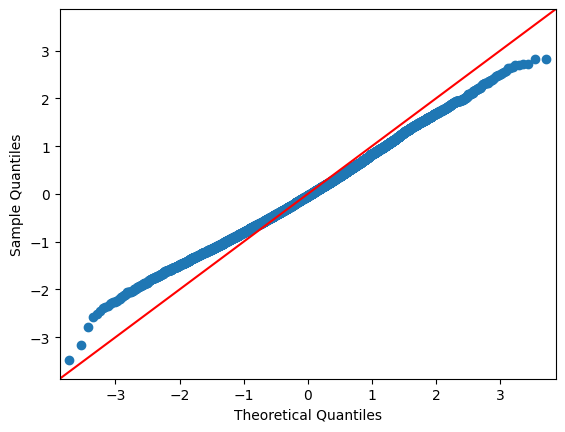

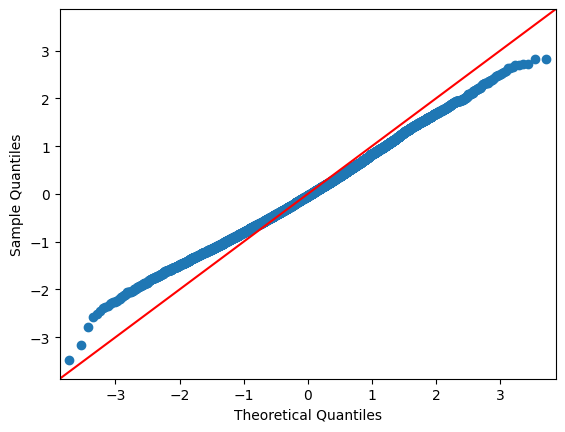

In [25]:
sm.qqplot(residuos, line="45")

Hetorodasticidade nas caudas

# Modelo 2: MULTINÍVEL

In [ ]:
#subset=['SG_UF_ESC', 'TP_DEPENDENCIA_ADM_ESC', 'TP_ENSINO']

Testando o ICC do agrupamento


In [16]:
media_grupais= df_copy.groupby("SG_UF_ESC")["MEDIA_CANDIDATO"].mean()
var_between = media_grupais.var()

var_within = df_copy.groupby("SG_UF_ESC")["MEDIA_CANDIDATO"].var().mean()

icc_naive = var_between / (var_between + var_within)
icc_naive


0.04891343932130746

Ensinando contexto ao modelo: 

In [ ]:
df_copy["RENDA_UF"] = df_copy.groupby("SG_UF_ESC")["RENDA"].transform("mean")
df_copy["ESCOLARIDADE_C"] = df_copy.groupby("SG_UF_ESC")["TP_ESCOLA"].transform("mean")
df_copy["INTERNET_UF"] = df_copy.groupby("SG_UF_ESC")["INTERNET"].transform("mean")
df_copy["SCORE_CULT_PAIS_UF"] = df_copy.groupby("SG_UF_ESC")["SCORE_CULT_PAIS"].transform("mean")
df_copy["SCORE_CONSUMO_UF"] = df_copy.groupby("SG_UF_ESC")["SCORE_CONSUMO"].transform("mean")


In [24]:
nova_formula = (
    'MEDIA_CANDIDATO ~  RENDA + SCORE_CULT_PAIS+'
    'C(TP_COR_RACA) + C(INTERNET)  + C(TP_ESCOLA)'
)


In [58]:
modelo_2=smf.mixedlm(formula=nova_formula, data=df_copy, groups=df_copy['SG_UF_ESC']).fit()
display(modelo_2.summary())

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:              MixedLM Dependent Variable: MEDIA_CANDIDATO
No. Observations:   880332  Method:             REML           
No. Groups:         27      Scale:              0.6635         
Min. group size:    1589    Log-Likelihood:     -1068679.1112  
Max. group size:    168445  Converged:          Yes            
Mean group size:    32604.9                                    
---------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept           -0.259    0.023 -11.039 0.000 -0.305 -0.213
C(TP_COR_RACA)[T.1]  0.110    0.006  17.315 0.000  0.097  0.122
C(TP_COR_RACA)[T.2] -0.062    0.007  -9.210 0.000 -0.075 -0.049
C(TP_COR_RACA)[T.3] -0.029    0.006  -4.610 0.000 -0.041 -0.017
C(TP_COR_RACA)[T.4]  0.017    0.008   2.062 0.039  0.001  0.034
C(TP_COR_RACA)[T.5] -0.221    0.013 -16.871 0.000 -0.247 -0.195
C(INTERNET)[T.1]     0.162    0.002  66.044 0.000  0.157  0.167
C(TP_ESCOLA)[T.3]    0.569    0.003 182.753 0.000  0.563  0.576
RENDA                0.119    0.001  90.832 0.000  0.117  0.122
SCORE_CULT_PAIS      0.207    0.001 188.832 0.000  0.205  0.209
SCORE_CONSUMO        0.121    0.001  83.837 0.000  0.119  0.124
Group Var            0.014    0.005                            
===============================================================

"""

In [59]:
0.014/0.660+0.014

0.03521212121212121

In [25]:
modelo_3=smf.mixedlm(formula=nova_formula, data=df_copy, groups=df_copy['SCORE_CONSUMO']).fit()

display(modelo_3.summary())

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:              MixedLM Dependent Variable: MEDIA_CANDIDATO
No. Observations:   880332  Method:             REML           
No. Groups:         76      Scale:              0.6708         
Min. group size:    1       Log-Likelihood:     -1073609.5499  
Max. group size:    95158   Converged:          Yes            
Mean group size:    11583.3                                    
---------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept           -0.163    0.019  -8.469 0.000 -0.201 -0.125
C(TP_COR_RACA)[T.1]  0.102    0.006  16.123 0.000  0.090  0.115
C(TP_COR_RACA)[T.2] -0.051    0.007  -7.632 0.000 -0.064 -0.038
C(TP_COR_RACA)[T.3] -0.028    0.006  -4.417 0.000 -0.040 -0.016
C(TP_COR_RACA)[T.4]  0.015    0.009   1.744 0.081 -0.002  0.032
C(TP_COR_RACA)[T.5] -0.232    0.013 -17.604 0.000 -0.258 -0.206
C(INTERNET)[T.1]     0.150    0.003  57.885 0.000  0.145  0.155
C(TP_ESCOLA)[T.3]    0.594    0.003 191.891 0.000  0.588  0.600
RENDA                0.148    0.001 106.318 0.000  0.146  0.151
SCORE_CULT_PAIS      0.187    0.001 169.690 0.000  0.185  0.189
Group Var            0.021    0.005                            
===============================================================

"""